<a href="https://colab.research.google.com/github/sathitvudh/stat453-deep-learning-project-2023/blob/main/EfficientNetV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import ceil
import os
import pandas as pd
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from itertools import product
%matplotlib inline

In [ ]:
####################################
### SETTINGS
####################################

# Initializing expand_ratio, channels, repeats, stride, kernel_size
# for base 

base_model = [
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3]
]

# Initializing config for each verion (phi_value, resolution, drop_rate)
version_config = {
    'b0': (0, 224, 0.2),
    'b1': (0.5, 240, 0.2),
    'b2': (1, 260, 0.3),
    'b3': (2, 300, 0.3),
    'b4': (3, 380, 0.4),
    'b5': (4, 456, 0.4)
}

# Hyperparameter setting
RANDOM_SEED = 1
NUM_CLASSES = 10 # using CIFAR-10
BATCH_SIZE = 128
NUM_EPOCHS = 50
version = "b0"
phi, res, drop_rate = version_config[version]
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

####################################
### CIFAR-10 DATASET
####################################

# Scale inout images to 0-1 range using transforms.ToTensor()

np.random.seed(RANDOM_SEED)
idx = np.arange(50000)
np.random.shuffle(idx)
val_idx, train_idx = idx[:1000], idx[1000:]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_dataset = datasets.CIFAR10(root = 'data',
                                 train = True,
                                 transform = transforms.ToTensor(),
                                 download = True)

test_dataset = datasets.CIFAR10(root = 'data',
                                 train = False,
                                 transform = transforms.ToTensor())

train_loader = DataLoader(dataset = train_dataset,
                         batch_size = BATCH_SIZE,
                         #shuffle = True,
                         sampler = train_sampler)

val_loader = DataLoader(dataset = train_dataset,
                       batch_size = BATCH_SIZE,
                       sampler = val_sampler)

test_loader = DataLoader(dataset = test_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle = False)

# Checking the dataset
for images, labels in train_loader:
    print('Image Batch Dimensions:', images.shape)
    print('Image Label Dimensions:', labels.shape)
    break

100%|██████████| 170498071/170498071 [00:05<00:00, 28641711.01it/s]


Extracting data/cifar-10-python.tar.gz to data
Image Batch Dimensions: torch.Size([128, 3, 32, 32])
Image Label Dimensions: torch.Size([128])


In [ ]:
####################################
### LEARNING RATE SETTINGS
####################################

iter_per_ep = len(train_loader.sampler.indices) // train_loader.batch_size
base_lr = 0.01
max_lr = 0.1
batch_step = -1
cur_lr = base_lr

In [ ]:
####################################
### MODEL
####################################

# 1. Start with Convolutional Neural Network block
# Con -> Batch_norm -> ReLU
class CNN_block(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size,
                 stride, padding, groups = 1):
        
        super(CNN_block, self).__init__()
        self.cnn = nn.Conv2d(in_ch, out_ch, kernel_size,
                             stride, padding, groups = groups,
                             bias = False) # If we set group = 1 -> normal conv, groups = in_ch -> Depthwise conv
        self.batch_norm = nn.BatchNorm2d(out_ch)
        self.silu = nn.SiLU() # SiLU == Swish
        
    def forward(self, x):
        
        out = self.cnn(x)
        out = self.batch_norm(out)
        out = self.silu(out)
        
        return out

# 2. Squeeze Excitation trick used inside Inverted Res block
class Squeeze_Excitation(nn.Module):
    def __init__(self, in_ch, reduced_dim):
        
        super(Squeeze_Excitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_ch, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_ch, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return x * self.se(x) # each channel, multiply the values from sequential (How much we should prioritize the channels)

# 3. Inverted Residual Block
class Inverted_Residual_block(nn.Module):
    # expand_ratio takes inputs and expands to higher number of channels
    # reduce by 1/4 (for squeeze excitation)
    # survival_prob is for stochastic depth
    def __init__(self, in_ch, out_ch, kernel_size,
                stride, padding, expand_ratio, reduction = 4,
                survival_prob = 0.8):
        
        super(Inverted_Residual_block, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_ch == out_ch and stride == 1
        hidden_dim = in_ch * expand_ratio
        self.expand = in_ch != hidden_dim
        reduced_dim = int(in_ch/reduction)
        
        if self.expand:
            self.expand_conv = CNN_block(in_ch,
                                        hidden_dim,
                                        kernel_size = 3,
                                        stride = 1,
                                        padding = 1)
        
        self.conv = nn.Sequential(
            CNN_block(
                hidden_dim, hidden_dim, kernel_size, stride,
                padding, groups = hidden_dim
            ),
            Squeeze_Excitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_ch, 1, bias = False),
            nn.BatchNorm2d(out_ch)
        )
    
    def Stochastic_Depth(self, x):
        if not self.training: # like-dropout, randomly remove certain layer
            return x
        # compute value 0 or 1 for each example
        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device = x.device) < self.survival_prob
        
        return torch.div(x, self.survival_prob) * binary_tensor # try to maintain mean and sd in the batch
        
    def forward(self, x):
        
        out = self.expand_conv(x) if self.expand else x
        
        if self.use_residual:
            return self.Stochastic_Depth(self.conv(out)) + x
        else: # if we down sampled or if the channel changed
            return self.conv(out)
        
class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.feature_extraction(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes)
        )
        
    def calculate_factors(self, version, alpha = 1.2, beta = 1.1):
        phi, resolution, drop_rate = version_config[version]
        depth_factor = alpha ** phi # how many layers we should increase for each stage
        width_factor = beta ** phi # how much larger the channels should be
        return depth_factor, width_factor, drop_rate
    
    def feature_extraction(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNN_block(3, channels, 3, stride = 2, padding = 1)]
        in_ch = channels
        
        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_ch = 4 *ceil(int(channels*width_factor)/4) # modulus of 4 since we identify reduction = 4 in SE
            layers_repeats = ceil(repeats * depth_factor)
            
            for layer in range(layers_repeats):
                features.append(
                    Inverted_Residual_block(
                        in_ch,
                        out_ch,
                        expand_ratio = expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size = kernel_size,
                        padding = kernel_size // 2, # if k=1 -> pad=0, k=3 -> pad=1, k=5-> pad=2
                    )
                )
                in_ch = out_ch
        features.append(
            CNN_block(in_ch, last_channels, kernel_size = 1,
                     stride = 1, padding = 0)
        )
        
        return nn.Sequential(*features)
    
    def forward(self, x):
        
        out = self.features(x)
        out = self.pool(out)
        
        return self.classifier(out.view(out.shape[0], -1))
    
def test():
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    version = "b0"
    phi, res, drop_rate = version_config[version]
    num_examples, num_classes = 4,10
    x = torch.randn((num_examples, 3, res, res)).to(DEVICE)
    model = EfficientNet(version = version,
                        num_classes = num_classes).to(DEVICE)
    
    print(model(x).shape) # (num_examples, num_classes)
    
#test()

In [ ]:
####################################
### CYCLICAL LEARNING RATE
####################################

def cyclical_learning_rate(batch_step,
                           step_size,
                           base_lr=0.001,
                           max_lr=0.006,
                           mode='triangular',
                           gamma=0.999995):

    cycle = np.floor(1 + batch_step / (2. * step_size))
    x = np.abs(batch_step / float(step_size) - 2 * cycle + 1)

    lr_delta = (max_lr - base_lr) * np.maximum(0, (1 - x))
    
    if mode == 'triangular':
        pass
    elif mode == 'triangular2':
        lr_delta = lr_delta * 1 / (2. ** (cycle - 1))
    elif mode == 'exp_range':
        lr_delta = lr_delta * (gamma**(batch_step))
    else:
        raise ValueError('mode must be "triangular", "triangular2", or "exp_range"')
        
    lr = base_lr + lr_delta
    
    return lr

In [ ]:
torch.manual_seed(RANDOM_SEED)

########################
### COST AND OPTIMIZER
########################

model = EfficientNet(version = version, num_classes = NUM_CLASSES).to(DEVICE)
model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr = base_lr)

In [ ]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        outputs = model(features)
        _, preds = torch.max(outputs, 1)
        cross_entropy += F.cross_entropy(outputs, targets)
        num_examples += targets.size(0)
        correct_pred += (preds == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    
collect = {'epoch': [], 'cost': [], 'train_cost':[], 
           'val_cost': [], 'train_acc': [], 'val_acc': [],
           'learn_rate': []}
start_time = time.time()
train_acc_lst, test_acc_lst = [], []
train_loss_lst, test_loss_lst = [], []
#f1_score_lst = []

for epoch in range(NUM_EPOCHS):
    collect['learn_rate'].append(base_lr)
    epoch_avg_cost = 0.
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        batch_step += 1
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        _, preds = torch.max(outputs, 1)
        cost = F.cross_entropy(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        #f1_score_lst.append(f1_score(targets, preds, average = "macro"))
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        epoch_avg_cost += cost
        
        ### LOGGING
        if not batch_idx % 20:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        val_acc, val_loss = compute_accuracy_and_loss(model, val_loader, device=DEVICE)
        #test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, device=DEVICE)
        epoch_avg_cost /= batch_idx + 1
        collect['epoch'].append(epoch+1)
        collect['train_acc'].append(train_acc)
        collect['train_cost'].append(train_loss)
        collect['val_acc'].append(val_acc)
        collect['val_cost'].append(val_loss)
        collect['cost'].append(epoch_avg_cost / iter_per_ep)
        print('base_lr: ', base_lr)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {val_acc:.2f}%')
    
    #############################################
    # Update learning rate
    base_lr = cyclical_learning_rate(batch_step=batch_step,
                                     step_size=NUM_EPOCHS*iter_per_ep,
                                     base_lr=base_lr,
                                     max_lr=max_lr)
    
    for g in optimizer.param_groups:
        g['lr'] = base_lr
    #############################################
    
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
    
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/050 | Batch 000/383 | Cost: 2.3412
Epoch: 001/050 | Batch 020/383 | Cost: 2.3098
Epoch: 001/050 | Batch 040/383 | Cost: 2.2588
Epoch: 001/050 | Batch 060/383 | Cost: 2.2183
Epoch: 001/050 | Batch 080/383 | Cost: 2.2047
Epoch: 001/050 | Batch 100/383 | Cost: 2.0364
Epoch: 001/050 | Batch 120/383 | Cost: 2.0159
Epoch: 001/050 | Batch 140/383 | Cost: 1.9425
Epoch: 001/050 | Batch 160/383 | Cost: 1.8223
Epoch: 001/050 | Batch 180/383 | Cost: 1.8921
Epoch: 001/050 | Batch 200/383 | Cost: 1.9810
Epoch: 001/050 | Batch 220/383 | Cost: 1.7669
Epoch: 001/050 | Batch 240/383 | Cost: 1.8324
Epoch: 001/050 | Batch 260/383 | Cost: 1.7292
Epoch: 001/050 | Batch 280/383 | Cost: 1.7018
Epoch: 001/050 | Batch 300/383 | Cost: 1.8159
Epoch: 001/050 | Batch 320/383 | Cost: 1.7702
Epoch: 001/050 | Batch 340/383 | Cost: 1.7456
Epoch: 001/050 | Batch 360/383 | Cost: 1.8304
Epoch: 001/050 | Batch 380/383 | Cost: 1.7482
base_lr:  0.01
Epoch: 001/050 Train Acc.: 39.84% | Validation Acc.: 38.60%
Time 

In [ ]:
## Now we test for the case when the learning rate is fixed

model_fixed = EfficientNet(version = version, num_classes = NUM_CLASSES).to(DEVICE)
model_fixed.to(DEVICE)

# base_lr = 0.01
optimizer_fixed = torch.optim.SGD(model_fixed.parameters(), lr = 0.01)

#f1_score_fixed = []
collect_fixed = {'epoch': [], 'train_cost': [], 'val_cost': [], 'train_acc': [], 'val_acc': []}
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_avg_cost_fixed = 0.
    model_fixed.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        batch_step += 1
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        outputs_fixed = model_fixed(features)
        _, preds_fixed = torch.max(outputs_fixed, 1)
        cost_fixed = F.cross_entropy(outputs_fixed, targets)
        optimizer_fixed.zero_grad()
        
        cost_fixed.backward()
        #f1_score_fixed.append(f1_score(targets, preds_fixed, average = "macro"))
        
        ### UPDATE MODEL PARAMETERS
        optimizer_fixed.step()
        
        epoch_avg_cost_fixed += cost
        
        ### LOGGING
        if not batch_idx % 20:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost_fixed:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model_fixed.eval()
    with torch.set_grad_enabled(False):
        train_acc_fixed, train_loss_fixed = compute_accuracy_and_loss(model_fixed, train_loader, device=DEVICE)
        val_acc_fixed, val_loss_fixed = compute_accuracy_and_loss(model_fixed, val_loader, device=DEVICE)
        #test_acc_fixed, test_loss_fixed = compute_accuracy_and_loss(model_fixed, test_loader, device=DEVICE)
        epoch_avg_cost_fixed /= batch_idx + 1
        collect_fixed['epoch'].append(epoch+1)
        collect_fixed['train_acc'].append(train_acc_fixed)
        collect_fixed['train_cost'].append(train_loss_fixed)
        collect_fixed['val_acc'].append(val_acc_fixed)
        collect_fixed['val_cost'].append(val_loss_fixed)
        #collect_fixed['cost'].append(epoch_avg_cost_fixed / iter_per_ep)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc_fixed:.2f}%'
              f' | Validation Acc.: {val_acc_fixed:.2f}%')
    
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/050 | Batch 000/383 | Cost: 2.4397
Epoch: 001/050 | Batch 020/383 | Cost: 2.3272
Epoch: 001/050 | Batch 040/383 | Cost: 2.1799
Epoch: 001/050 | Batch 060/383 | Cost: 2.1449
Epoch: 001/050 | Batch 080/383 | Cost: 2.1788
Epoch: 001/050 | Batch 100/383 | Cost: 2.0621
Epoch: 001/050 | Batch 120/383 | Cost: 2.0897
Epoch: 001/050 | Batch 140/383 | Cost: 2.1092
Epoch: 001/050 | Batch 160/383 | Cost: 1.9883
Epoch: 001/050 | Batch 180/383 | Cost: 1.9173
Epoch: 001/050 | Batch 200/383 | Cost: 2.0003
Epoch: 001/050 | Batch 220/383 | Cost: 1.7983
Epoch: 001/050 | Batch 240/383 | Cost: 1.8931
Epoch: 001/050 | Batch 260/383 | Cost: 1.9638
Epoch: 001/050 | Batch 280/383 | Cost: 1.7825
Epoch: 001/050 | Batch 300/383 | Cost: 1.7869
Epoch: 001/050 | Batch 320/383 | Cost: 1.7576
Epoch: 001/050 | Batch 340/383 | Cost: 1.6870
Epoch: 001/050 | Batch 360/383 | Cost: 1.7001
Epoch: 001/050 | Batch 380/383 | Cost: 1.6509
Epoch: 001/050 Train Acc.: 39.17% | Validation Acc.: 37.90%
Time elapsed: 0.55 m

In [ ]:
# Cyclical LR model test accuracy

model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 75.37%


In [ ]:
# Fixed LR model test accuracy

model_fixed.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc_fixed, test_loss_fixed = compute_accuracy_and_loss(model_fixed, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc_fixed:.2f}%')

Test accuracy: 68.84%


In [ ]:
# convert tensor to numpy
train_cost_lst = [i.detach().cpu().numpy() for i in collect['train_cost']]
train_acc_lst = [i.detach().cpu().numpy() for i in collect['train_acc']]
val_cost_lst = [i.detach().cpu().numpy() for i in collect['val_cost']]
val_acc_lst = [i.detach().cpu().numpy() for i in collect['val_acc']]

train_cost_fixed_lst = [i.detach().cpu().numpy() for i in collect_fixed['train_cost']]
train_acc_fixed_lst = [i.detach().cpu().numpy() for i in collect_fixed['train_acc']]
val_cost_fixed_lst = [i.detach().cpu().numpy() for i in collect_fixed['val_cost']]
val_acc_fixed_lst = [i.detach().cpu().numpy() for i in collect_fixed['val_acc']]

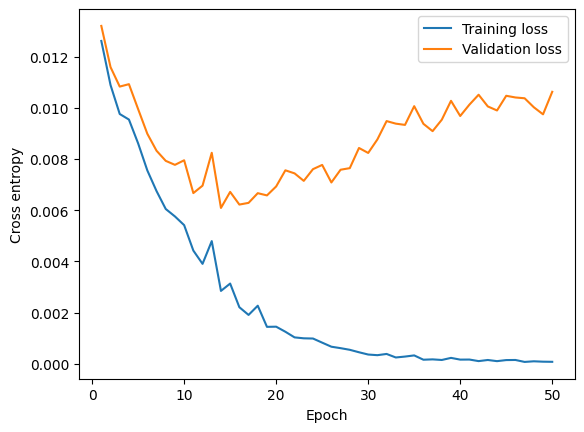

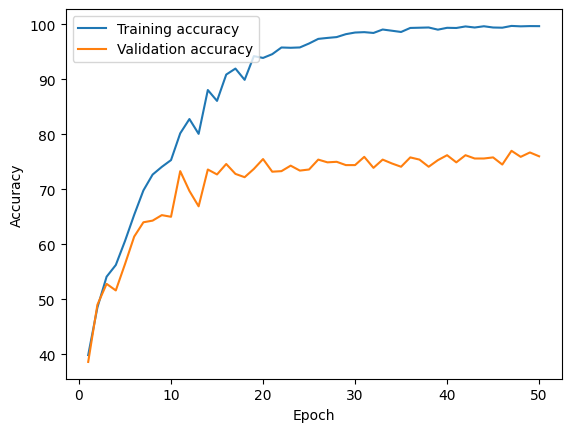

In [ ]:
# Cyclical LR model plot

# Cost plot
plt.plot(range(1, NUM_EPOCHS+1), train_cost_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), val_cost_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

# Accuracy plot
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), val_acc_lst, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

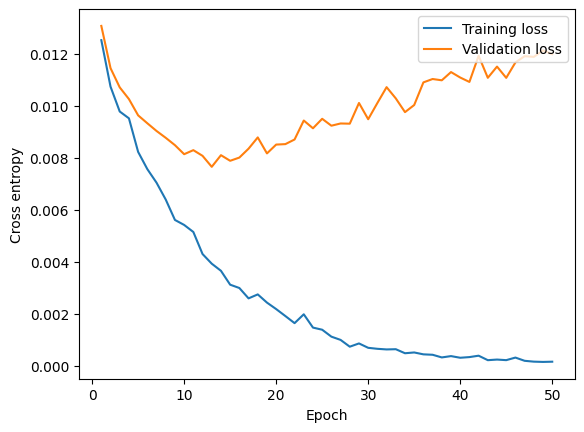

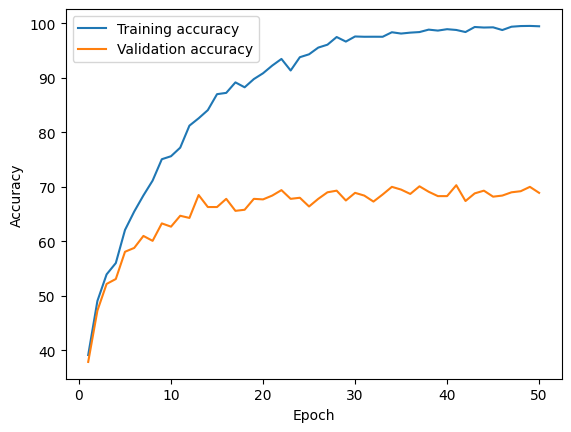

In [ ]:
# Fixed LR model plots

# Cost plot
plt.plot(range(1, NUM_EPOCHS+1), train_cost_fixed_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), val_cost_fixed_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

# Accuracy plot
plt.plot(range(1, NUM_EPOCHS+1), train_acc_fixed_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), val_acc_fixed_lst, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
        
    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

In [ ]:
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

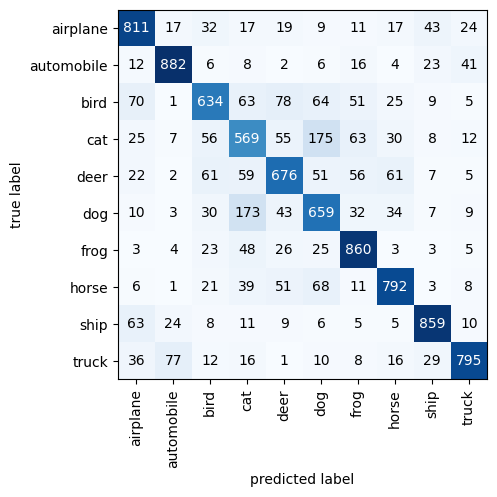

In [ ]:
# Cyclical LR model confusion matrix

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=DEVICE)
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

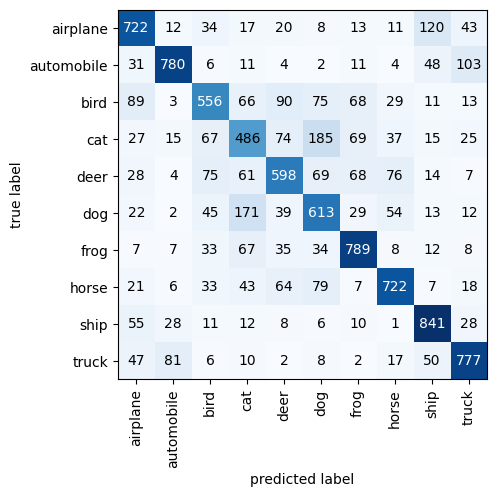

In [ ]:
# Fixed LR model confusion matrix

mat_fixed = compute_confusion_matrix(model=model_fixed, data_loader=test_loader, device=DEVICE)
plot_confusion_matrix(mat_fixed, class_names=class_dict.values())
plt.show()